In [1]:
import numpy as np                               # vectors and matrices
import pandas as pd                              # tables and data manipulations
import matplotlib.pyplot as plt                  # plots
import seaborn as sns                            # more plots
sns.set()

from dateutil.relativedelta import relativedelta # working with dates with style
from scipy.optimize import minimize              # for function minimization

import statsmodels.formula.api as smf            # statistics and econometrics
import statsmodels.tsa.api as smt
import statsmodels.api as sm
import scipy.stats as scs

from itertools import product                    # some useful functions
from tqdm import tqdm_notebook

import warnings                                  # `do not disturbe` mode
warnings.filterwarnings('ignore')

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [2]:
data = pd.read_csv('data_per_hour.csv', index_col=['Time'], 
                  parse_dates=['Time'])

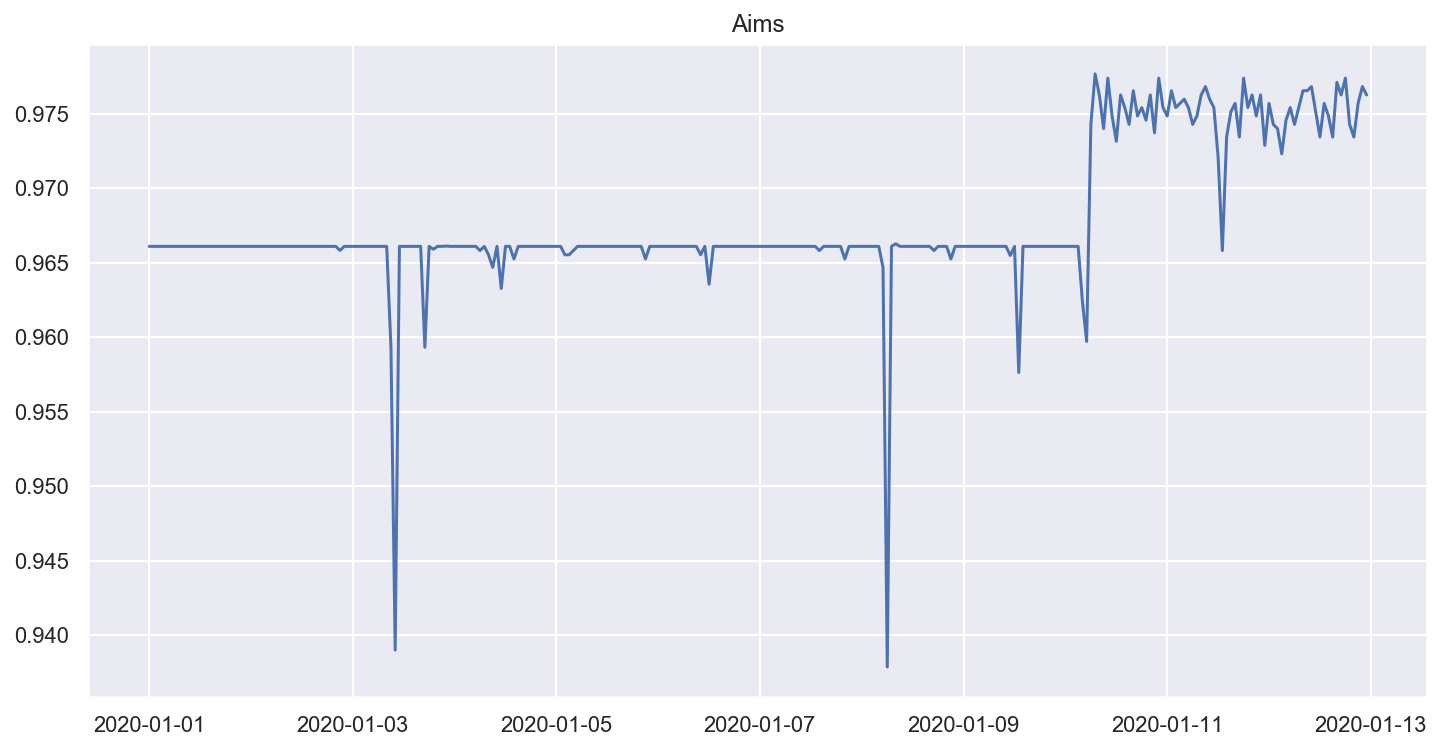

In [146]:
plt.figure(figsize=(12, 6))
plt.plot(data.Summary)
plt.title('Aims')
plt.grid(True)
plt.show()

In [3]:
len(data)

288

In [147]:
from sklearn.metrics import r2_score, median_absolute_error, mean_absolute_error
from sklearn.metrics import median_absolute_error, mean_squared_error, mean_squared_log_error

def mean_absolute_percentage_error(y_true, y_pred): 
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

In [148]:
data.columns = ["y"]

In [149]:
for i in (1,3,6,12*6,24*6):
    data["lag_{}".format(i)] = data.y.shift(i)

In [150]:
data

,y,lag_1,lag_3,lag_6,lag_72,lag_144
Time,,,,,,
2020-01-01 00:00:00,0.966102,NaN,NaN,NaN,NaN,NaN
2020-01-01 01:00:00,0.966102,0.966102,NaN,NaN,NaN,NaN
2020-01-01 02:00:00,0.966102,0.966102,NaN,NaN,NaN,NaN
2020-01-01 03:00:00,0.966102,0.966102,0.966102,NaN,NaN,NaN
2020-01-01 04:00:00,0.966102,0.966102,0.966102,NaN,NaN,NaN
...,...,...,...,...,...,...
2020-01-12 19:00:00,0.974294,0.977401,0.977119,0.975706,0.966102,0.966102
2020-01-12 20:00:00,0.973446,0.974294,0.976271,0.974859,0.966102,0.966102
2020-01-12 21:00:00,0.975706,0.973446,0.977401,0.973446,0.966102,0.966102


In [151]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import TimeSeriesSplit
tscv = TimeSeriesSplit(n_splits=5)

In [152]:
def timeseries_train_test_split(X, y, test_size):
    
    test_index = int(len(X)*(1-test_size))
    X_train = X.iloc[:test_index]
    y_train = y.iloc[:test_index]
    X_test = X.iloc[test_index:]
    y_test = y.iloc[test_index:]
    
    return X_train, X_test, y_train, y_test

In [153]:
y = data.dropna().y
X = data.dropna().drop(['y'], axis=1)
X_train, X_test, y_train, y_test = timeseries_train_test_split(X, y, test_size=0.3)


In [154]:
y_train

Time
2020-01-07 00:00:00    0.966102
2020-01-07 01:00:00    0.966102
2020-01-07 02:00:00    0.966102
2020-01-07 03:00:00    0.966102
2020-01-07 04:00:00    0.966102
                         ...   
2020-01-10 23:00:00    0.975424
2020-01-11 00:00:00    0.974859
2020-01-11 01:00:00    0.976554
2020-01-11 02:00:00    0.975424
2020-01-11 03:00:00    0.975706
Name: y, Length: 100, dtype: float64

In [155]:
# machine learning in two lines
lr = LinearRegression()
lr.fit(X_train, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [156]:
def plotModelResults(model, X_train=X_train, X_test=X_test, plot_intervals=False, plot_anomalies=False):
    """
        Plots modelled vs fact values, prediction intervals and anomalies
    
    """
    
    prediction = model.predict(X_test)
    
    plt.figure(figsize=(15, 7))
    plt.plot(prediction, "g", label="prediction", linewidth=2.0)
    plt.plot(y_test.values, label="actual", linewidth=2.0)
    
    if plot_intervals:
        cv = cross_val_score(model, X_train, y_train, 
                                    cv=tscv, 
                                    scoring="neg_mean_absolute_error")
        mae = cv.mean() * (-1)
        deviation = cv.std()
        mae =  mean_absolute_error( prediction, y_test)
        deviation = np.std(y_test - prediction)        
        print(mae)
        scale = 1.96
        lower = prediction - (mae + scale * deviation)
        upper = prediction + (mae + scale * deviation)
        
        plt.plot(lower, "r--", label="upper bond / lower bond", alpha=0.5)
        plt.plot(upper, "r--", alpha=0.5)
        
        if plot_anomalies:
            anomalies = np.array([np.NaN]*len(y_test))
            anomalies[y_test<lower] = y_test[y_test<lower]
            anomalies[y_test>upper] = y_test[y_test>upper]
            plt.plot(anomalies, "o", markersize=10, label = "Anomalies")
    
    error = mean_absolute_percentage_error(prediction, y_test)
    plt.title("Mean absolute percentage error {0:.2f}%".format(error))
    plt.legend(loc="best")
    plt.tight_layout()
    plt.grid(True);
    
def plotCoefficients(model):
    """
        Plots sorted coefficient values of the model
    """
    
    coefs = pd.DataFrame(model.coef_, X_train.columns)
    coefs.columns = ["coef"]
    coefs["abs"] = coefs.coef.apply(np.abs)
    coefs = coefs.sort_values(by="abs", ascending=False).drop(["abs"], axis=1)
    
    plt.figure(figsize=(15, 7))
    coefs.coef.plot(kind='bar')
    plt.grid(True, axis='y')
    plt.hlines(y=0, xmin=0, xmax=len(coefs), linestyles='dashed');

0.0019043834859096048


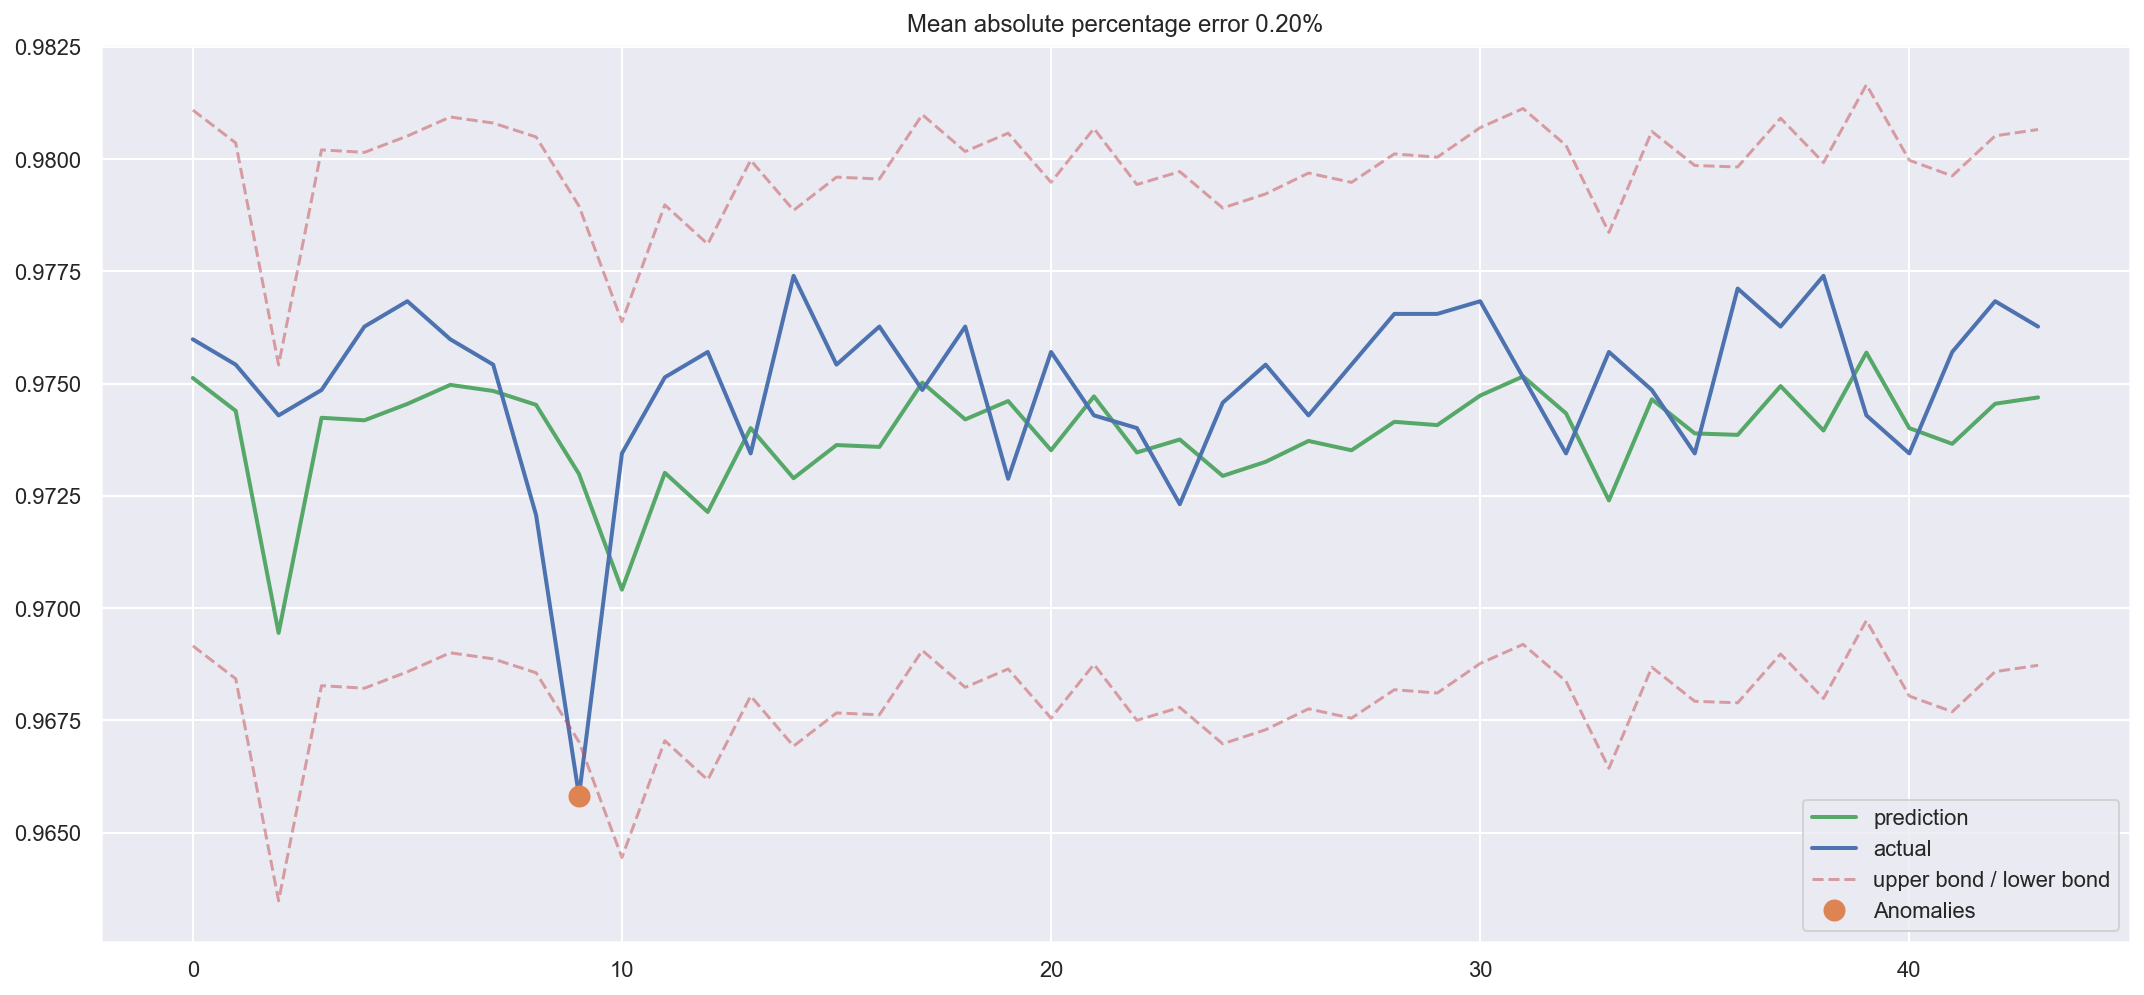

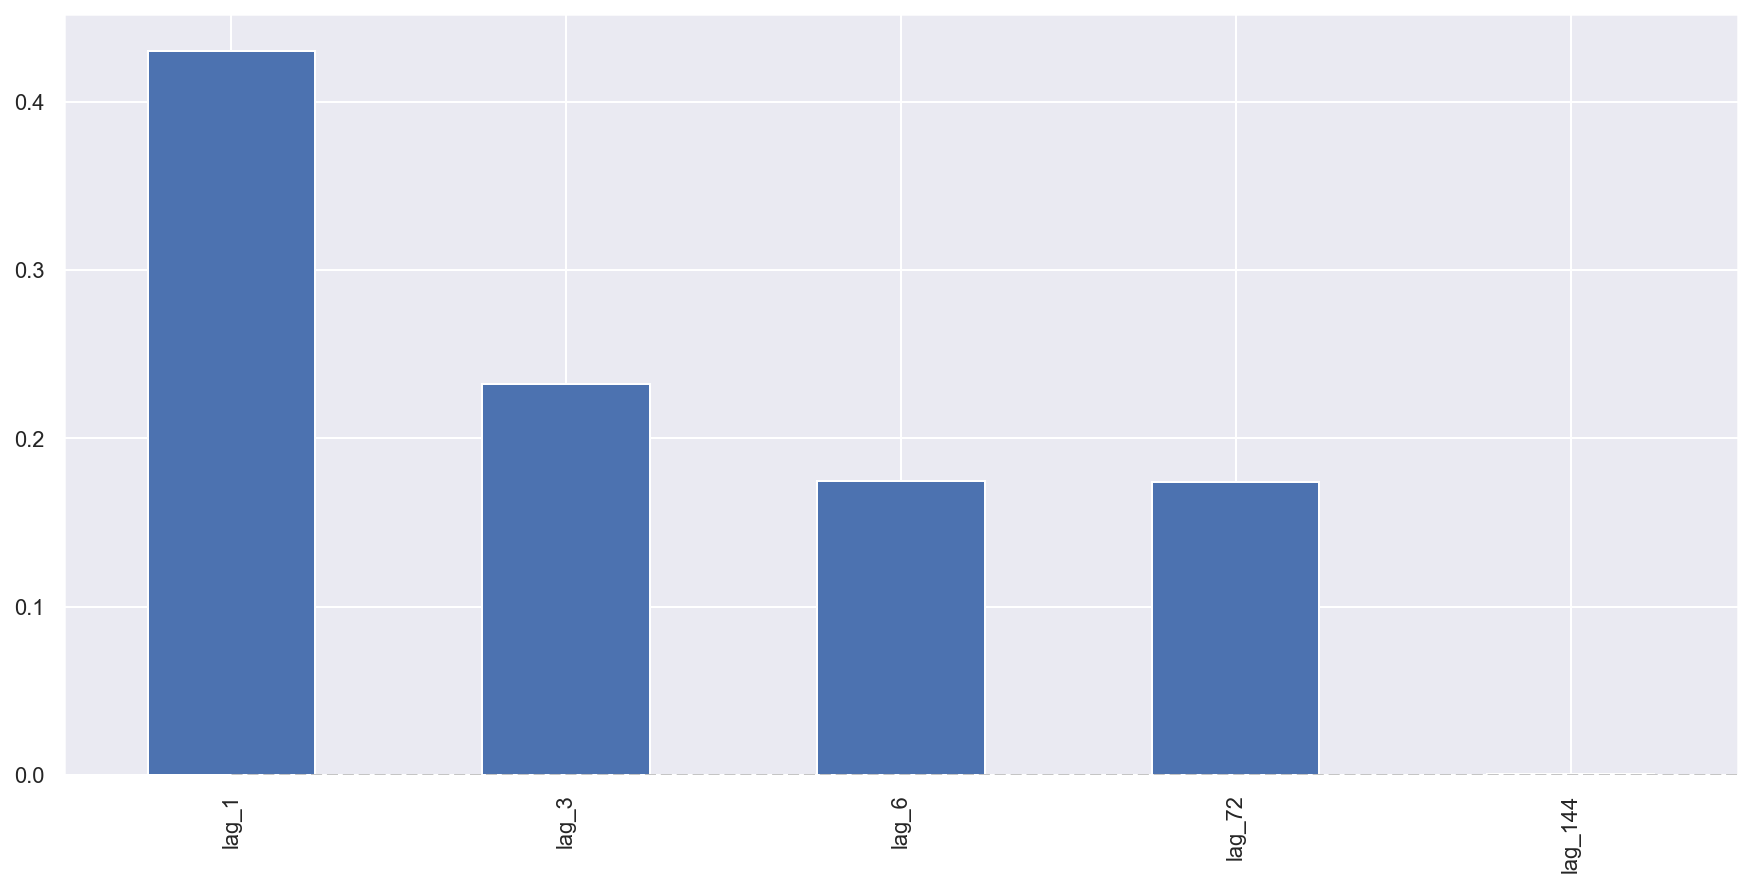

In [157]:
plotModelResults(lr, plot_intervals=True, plot_anomalies=True)
plotCoefficients(lr)

In [158]:
data.index = pd.to_datetime(data.index)
data["hour"] = data.index.hour
data["weekday"] = data.index.weekday
data['is_weekend'] = data.weekday.isin([5,6])*1
data.tail()

,y,lag_1,lag_3,lag_6,lag_72,lag_144,hour,weekday,is_weekend
Time,,,,,,,,,
2020-01-12 19:00:00,0.974294,0.977401,0.977119,0.975706,0.966102,0.966102,19,6,1
2020-01-12 20:00:00,0.973446,0.974294,0.976271,0.974859,0.966102,0.966102,20,6,1
2020-01-12 21:00:00,0.975706,0.973446,0.977401,0.973446,0.966102,0.966102,21,6,1
2020-01-12 22:00:00,0.976836,0.975706,0.974294,0.977119,0.966102,0.966102,22,6,1
2020-01-12 23:00:00,0.976271,0.976836,0.973446,0.976271,0.966102,0.966102,23,6,1


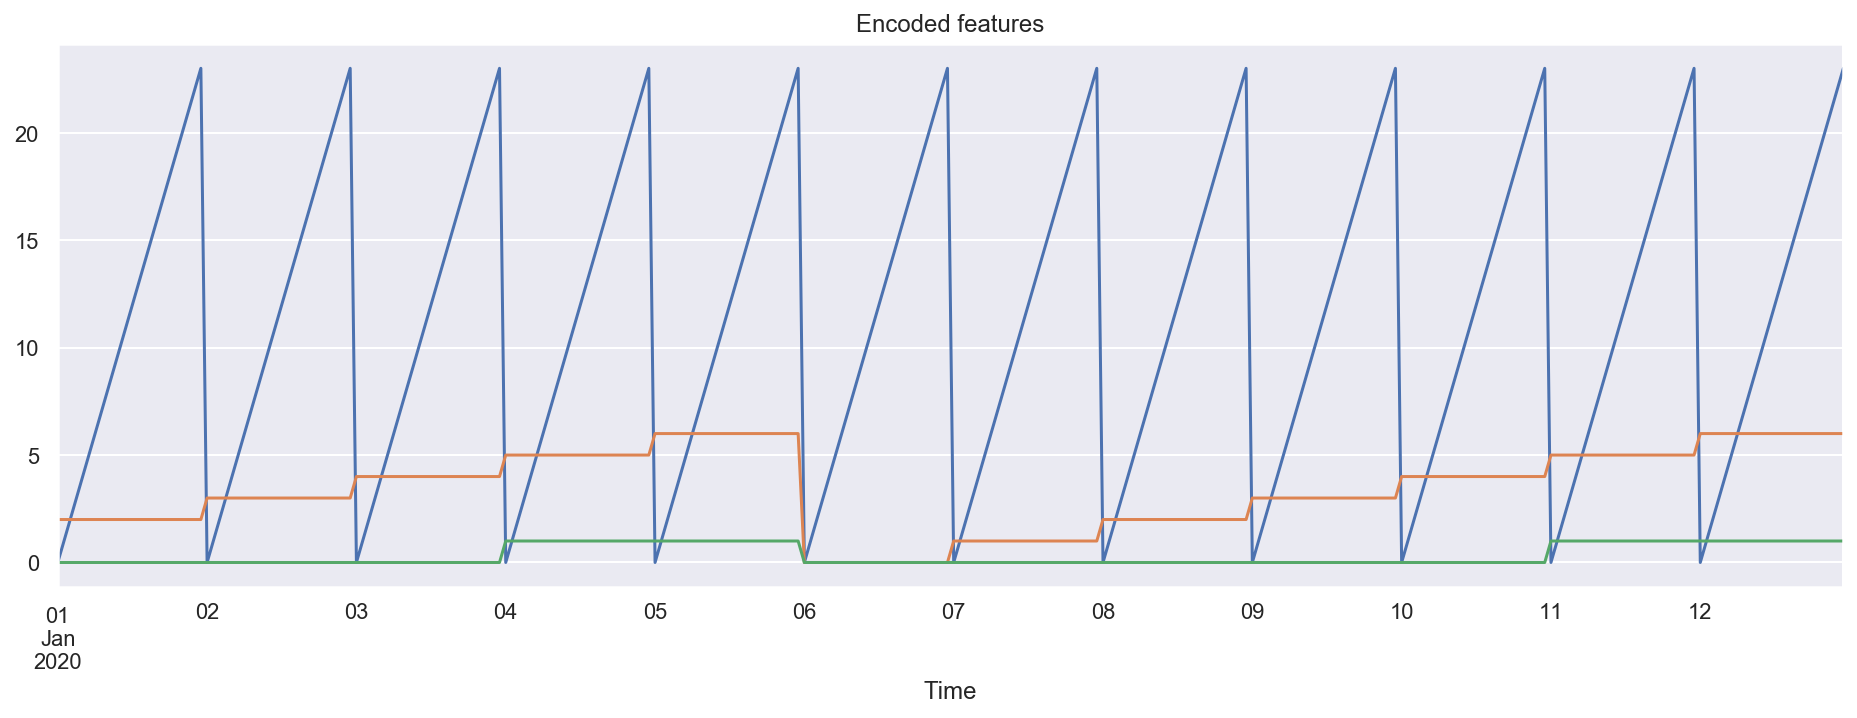

In [159]:
plt.figure(figsize=(16, 5))
plt.title("Encoded features")
data.hour.plot()
data.weekday.plot()
data.is_weekend.plot()
plt.grid(True);

In [160]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()

0.0019565657718216807


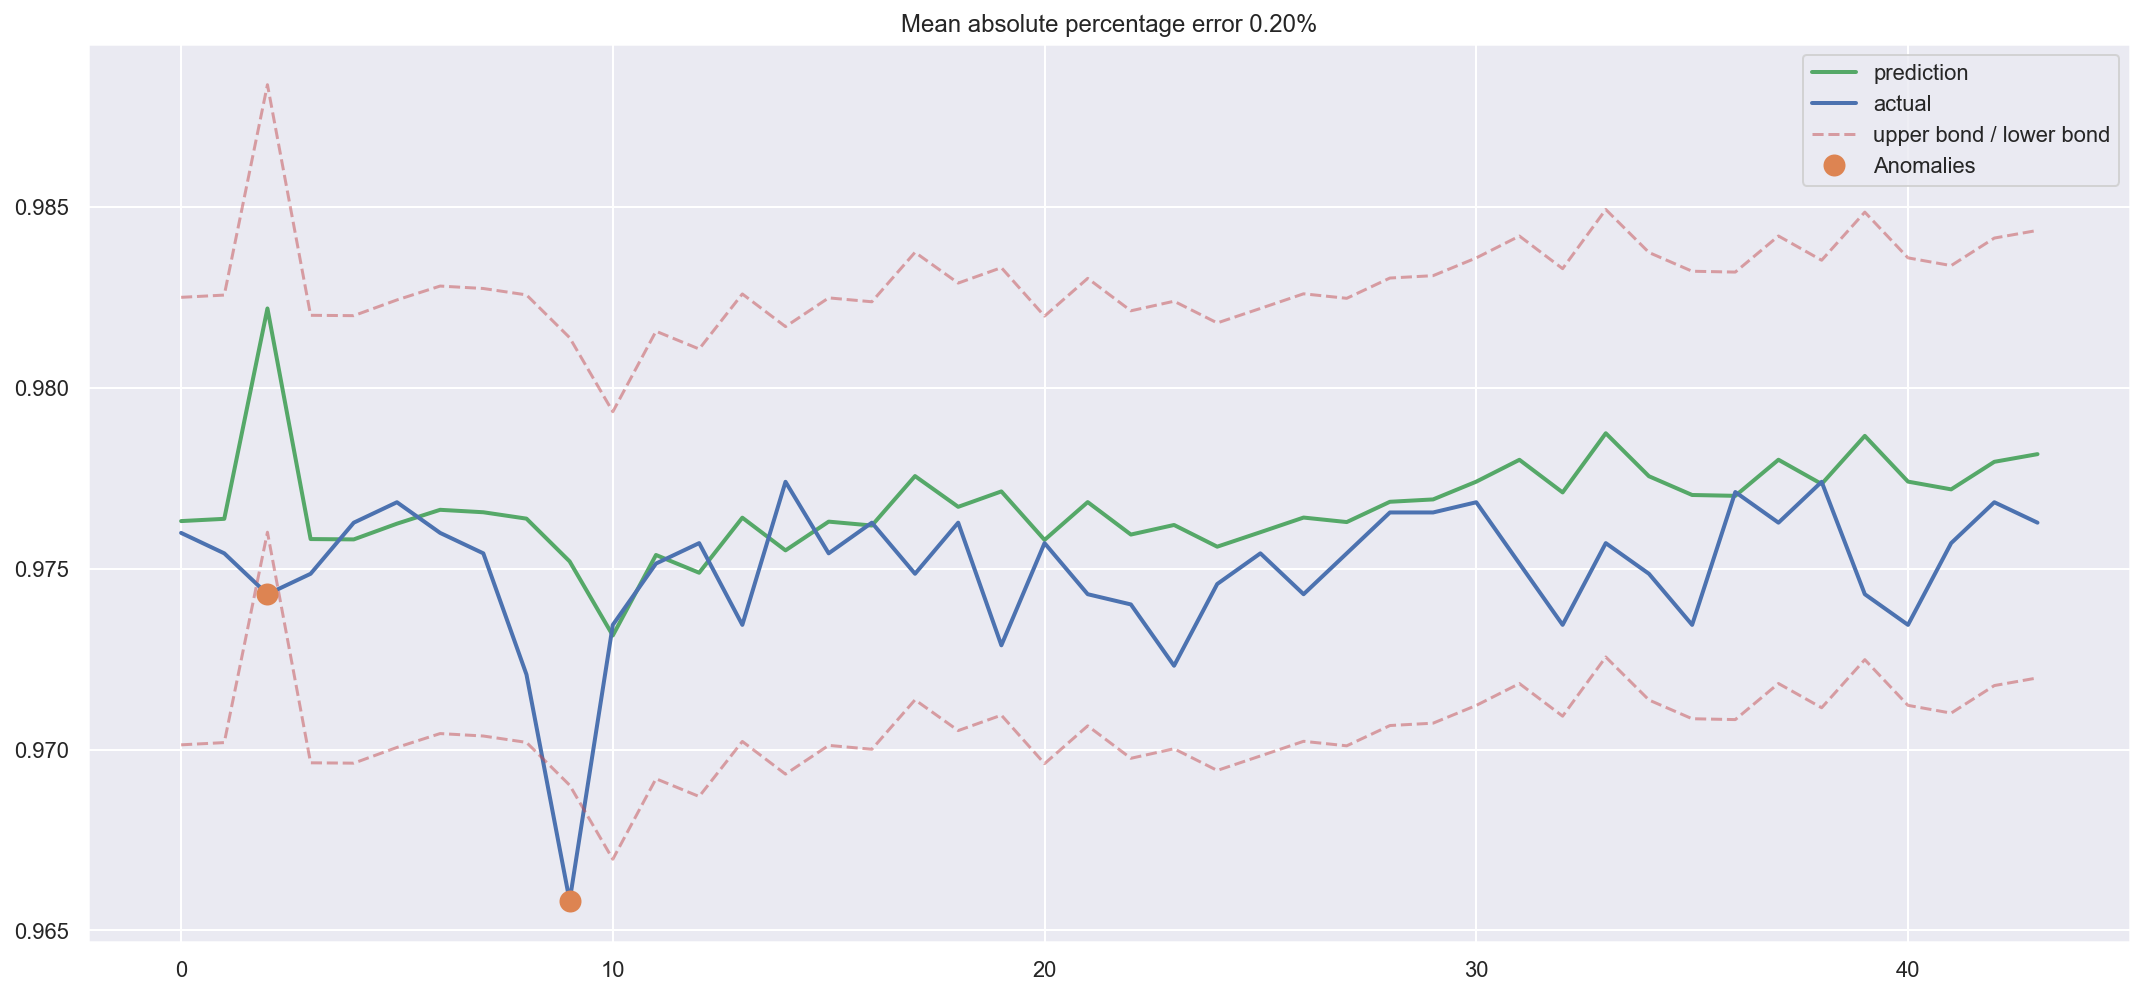

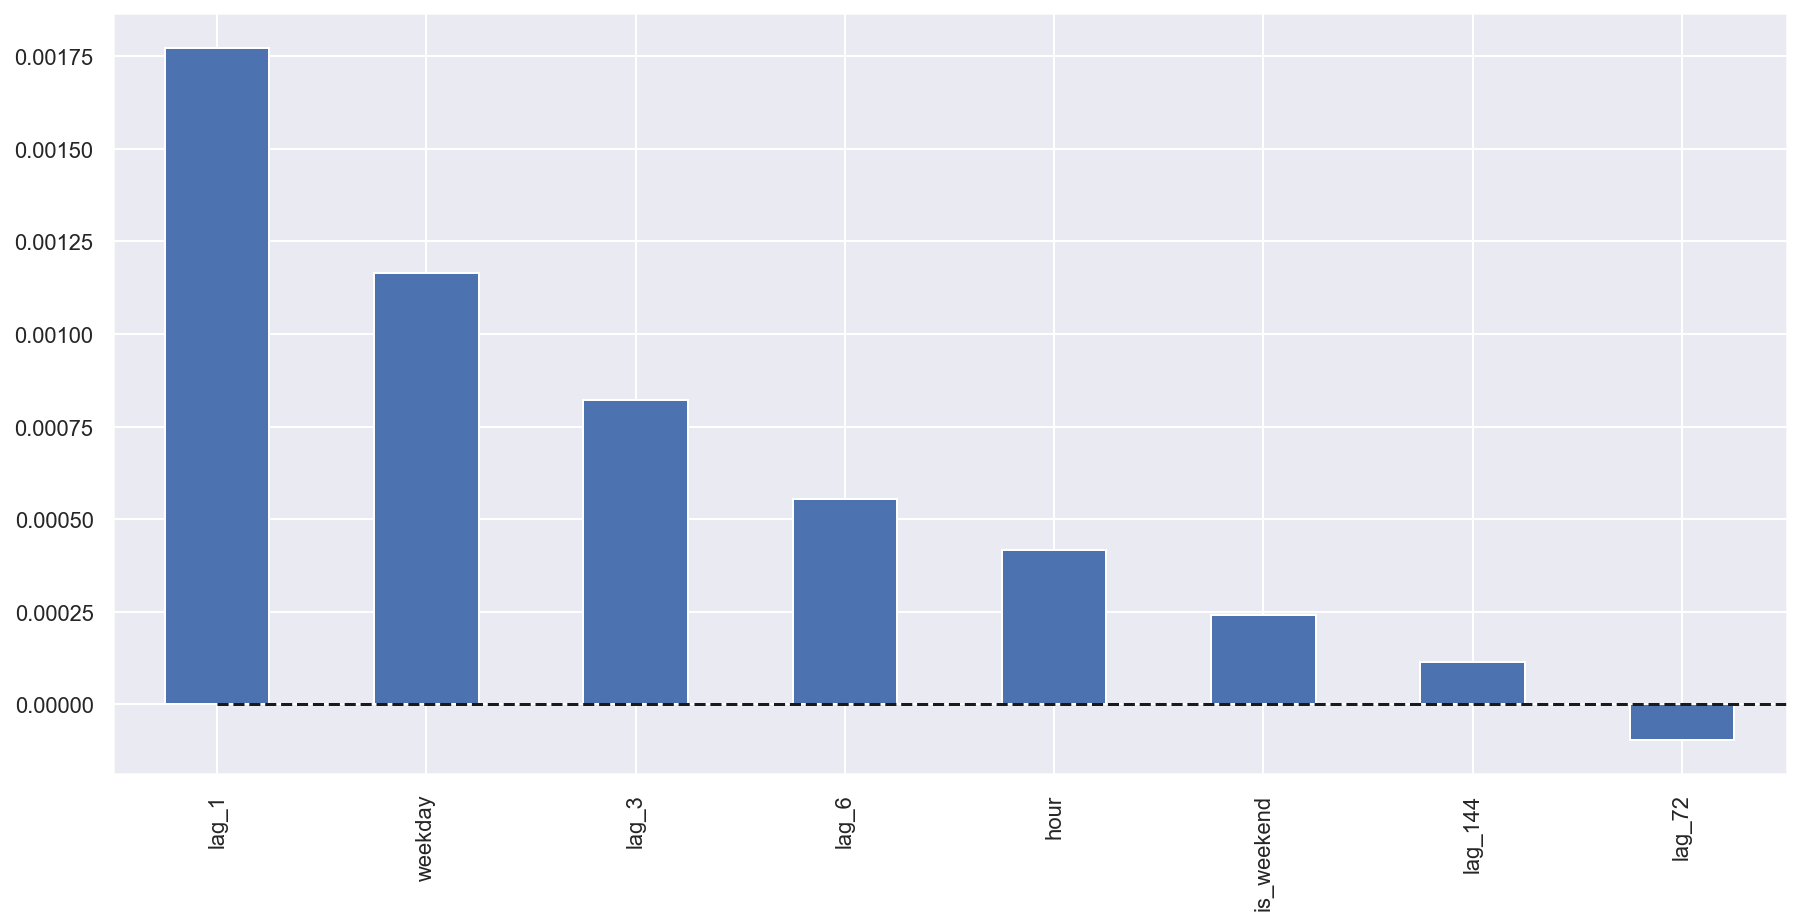

In [161]:
y = data.dropna().y
X = data.dropna().drop(['y'], axis=1)

X_train, X_test, y_train, y_test = timeseries_train_test_split(X, y, test_size=0.3)

X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

lr = LinearRegression()
lr.fit(X_train_scaled, y_train)

plotModelResults(lr, X_train=X_train_scaled, X_test=X_test_scaled, plot_intervals=True, plot_anomalies=True)
plotCoefficients(lr)

In [162]:
def code_mean(data, cat_feature, real_feature):
    """
    Returns a dictionary where keys are unique categories of the cat_feature,
    and values are means over real_feature
    """
    return dict(data.groupby(cat_feature)[real_feature].mean())

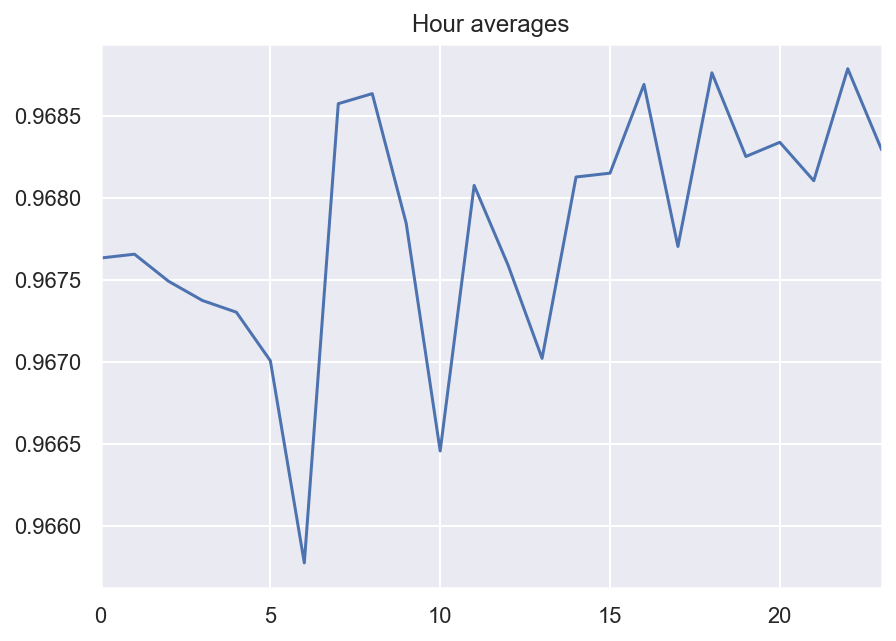

In [163]:
average_hour = code_mean(data, 'hour', "y")
plt.figure(figsize=(7, 5))
plt.title("Hour averages")
pd.DataFrame.from_dict(average_hour, orient='index')[0].plot()
plt.grid(True);

In [164]:
def prepareData(series, lag_start, lag_end, test_size, target_encoding=False):
    """
        series: pd.DataFrame
            dataframe with timeseries

        lag_start: int
            initial step back in time to slice target variable 
            example - lag_start = 1 means that the model 
                      will see yesterday's values to predict today

        lag_end: int
            final step back in time to slice target variable
            example - lag_end = 4 means that the model 
                      will see up to 4 days back in time to predict today

        test_size: float
            size of the test dataset after train/test split as percentage of dataset

        target_encoding: boolean
            if True - add target averages to the dataset
        
    """
    
    # copy of the initial dataset
    data = pd.DataFrame(series.copy())
    data.columns = ["y"]
    
    # lags of series
    for i in range(lag_start, lag_end):
        data["lag_{}".format(i)] = data.y.shift(i)
    
    # datetime features
    data.index = pd.to_datetime(data.index)
    data["hour"] = data.index.hour
    data["weekday"] = data.index.weekday
    data['is_weekend'] = data.weekday.isin([5,6])*1
    
    if target_encoding:
        # calculate averages on train set only
        test_index = int(len(data.dropna())*(1-test_size))
        data['weekday_average'] = list(map(code_mean(data[:test_index], 'weekday', "y").get, data.weekday))
        data["hour_average"] = list(map(code_mean(data[:test_index], 'hour', "y").get, data.hour))

        # drop encoded variables 
        data.drop(["hour", "weekday"], axis=1, inplace=True)
    
    # train-test split
    y = data.dropna().y
    X = data.dropna().drop(['y'], axis=1)
    X_train, X_test, y_train, y_test = timeseries_train_test_split(X, y, test_size=test_size)

    return X_train, X_test, y_train, y_test

0.01066905009274821


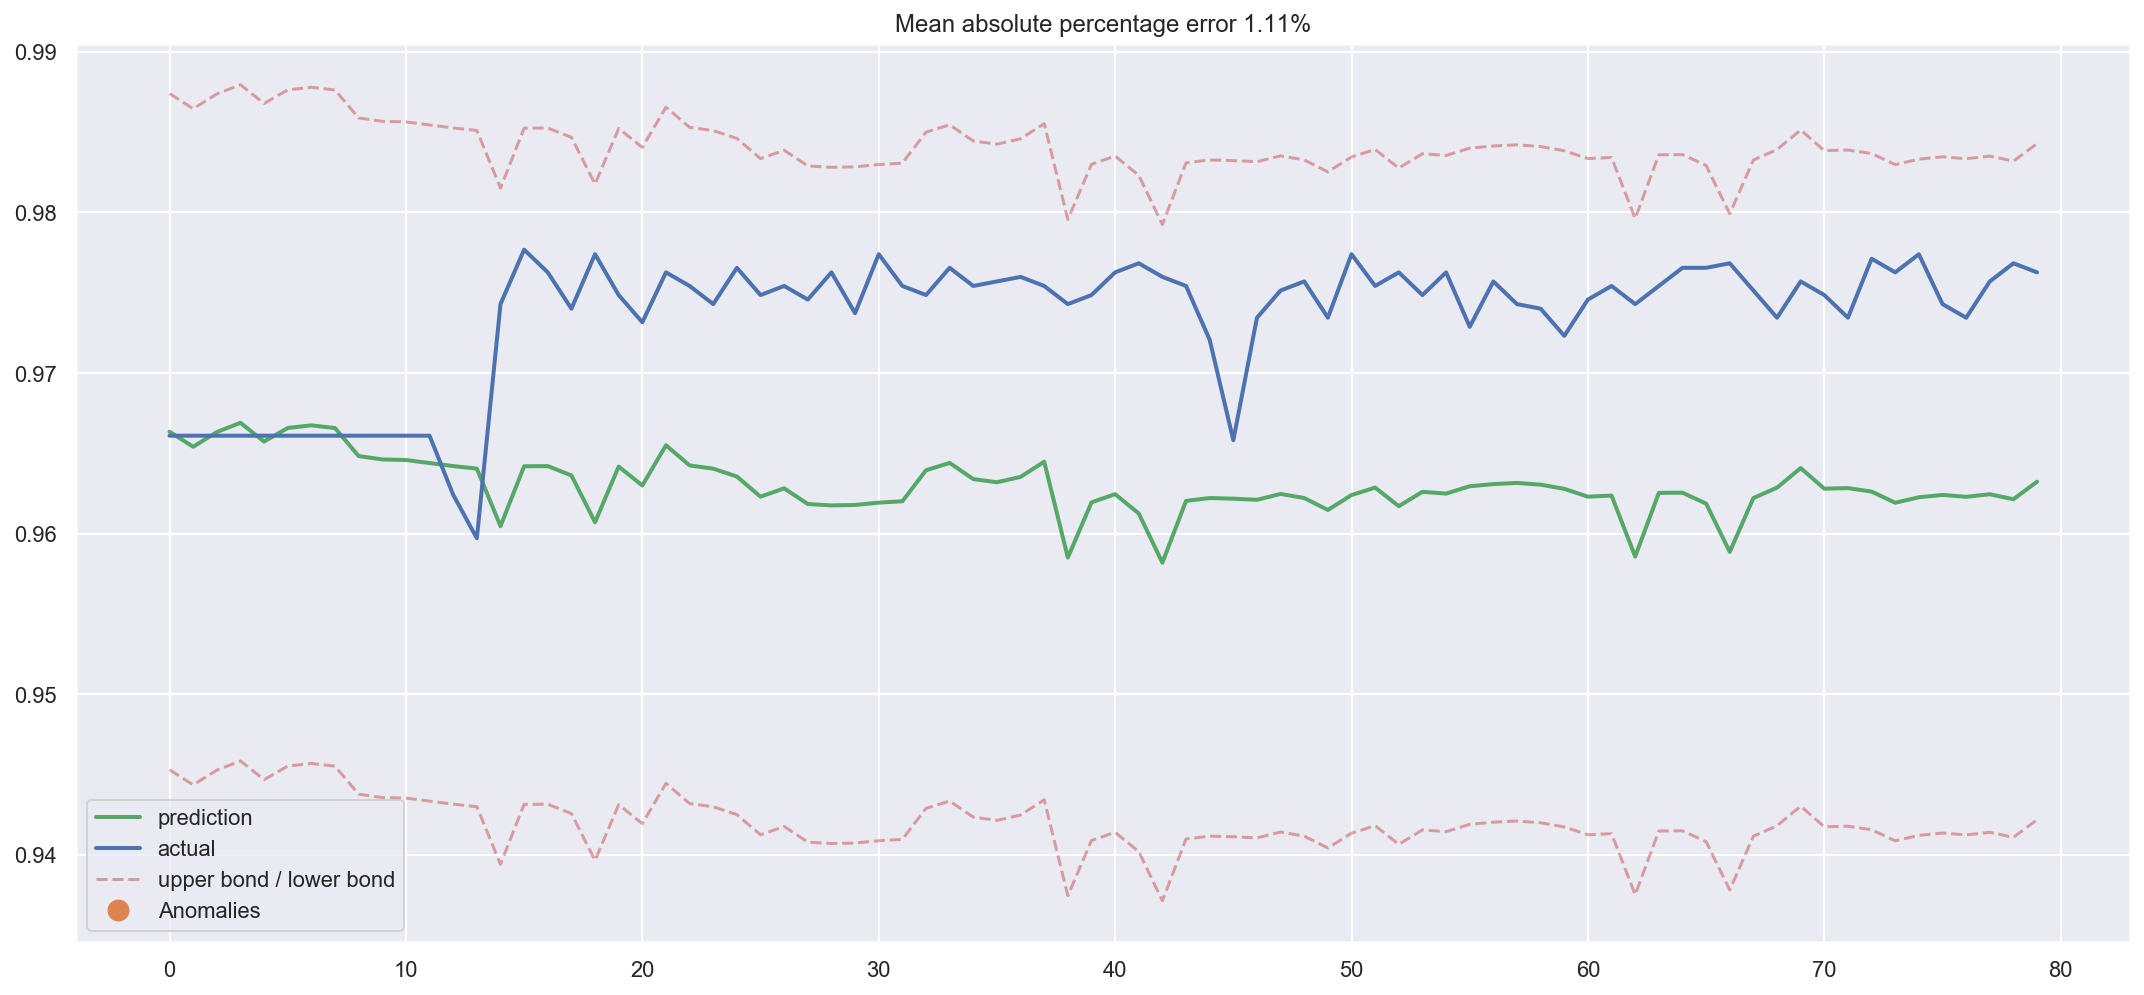

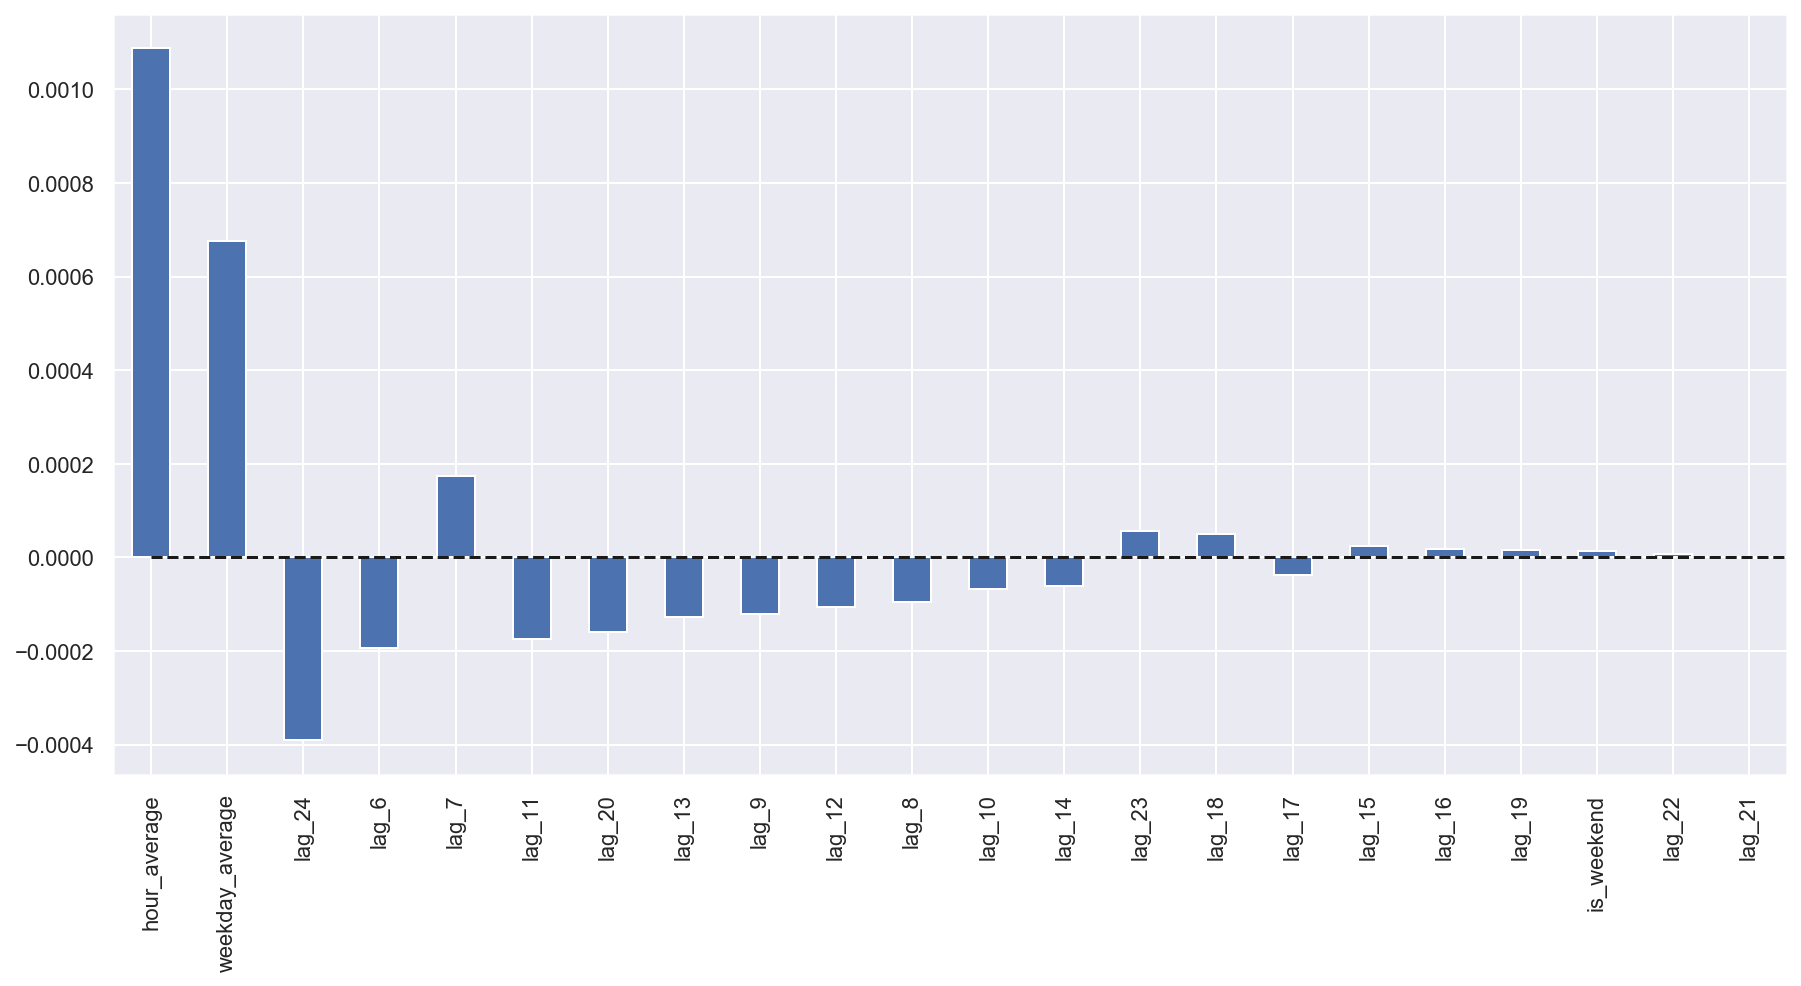

In [165]:
X_train, X_test, y_train, y_test =\
prepareData(data.y, lag_start=6, lag_end=25, test_size=0.3, target_encoding=True)

X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

lr = LinearRegression()
lr.fit(X_train_scaled, y_train)

plotModelResults(lr, X_train=X_train_scaled, X_test=X_test_scaled, plot_intervals=True, plot_anomalies=True)
plotCoefficients(lr)

We see some **overfitting**! `Hour_average` was so great in the training dataset that the model decided to concentrate all of its forces on it. As a result, the quality of prediction dropped. This problem can be solved in a variety of ways; for example, we can calculate the target encoding not for the whole train set, but for some window instead. That way, encodings from the last observed window will most likely better describe the current series state. Alternatively, we can just drop it manually since we are sure that it makes things only worse in this case. 

In [166]:
X_train, X_test, y_train, y_test =\
prepareData(data.y, lag_start=6, lag_end=25, test_size=0.3, target_encoding=False)

X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

## Regularization and feature selection 

As we already know, not all features are equally healthy -- some may lead to overfitting while others should be removed. Besides manual inspection, we can apply regularization. Two of the most popular regression models with regularization are Ridge and Lasso regressions. They both add some more constrains to our loss function. 

In the case of Ridge regression, those constraints are the sum of squares of the coefficients multiplied by the regularization coefficient. The bigger the coefficient a feature has, the bigger our loss will be. Hence, we will try to optimize the model while keeping the coefficients fairly low. 

As a result of this $L2$ regularization, we will have higher bias and lower variance, so the model will generalize better (at least that's what we hope will happen).

The second regression model, Lasso regression, adds to the loss function, not squares, but absolute values of the coefficients. As a result, during the optimization process, coefficients of unimportant features may become zeroes, which allows for automated feature selection. This regularization type is called $L1$. 

First, let's make sure that we have features to drop and that the data has highly correlated features.

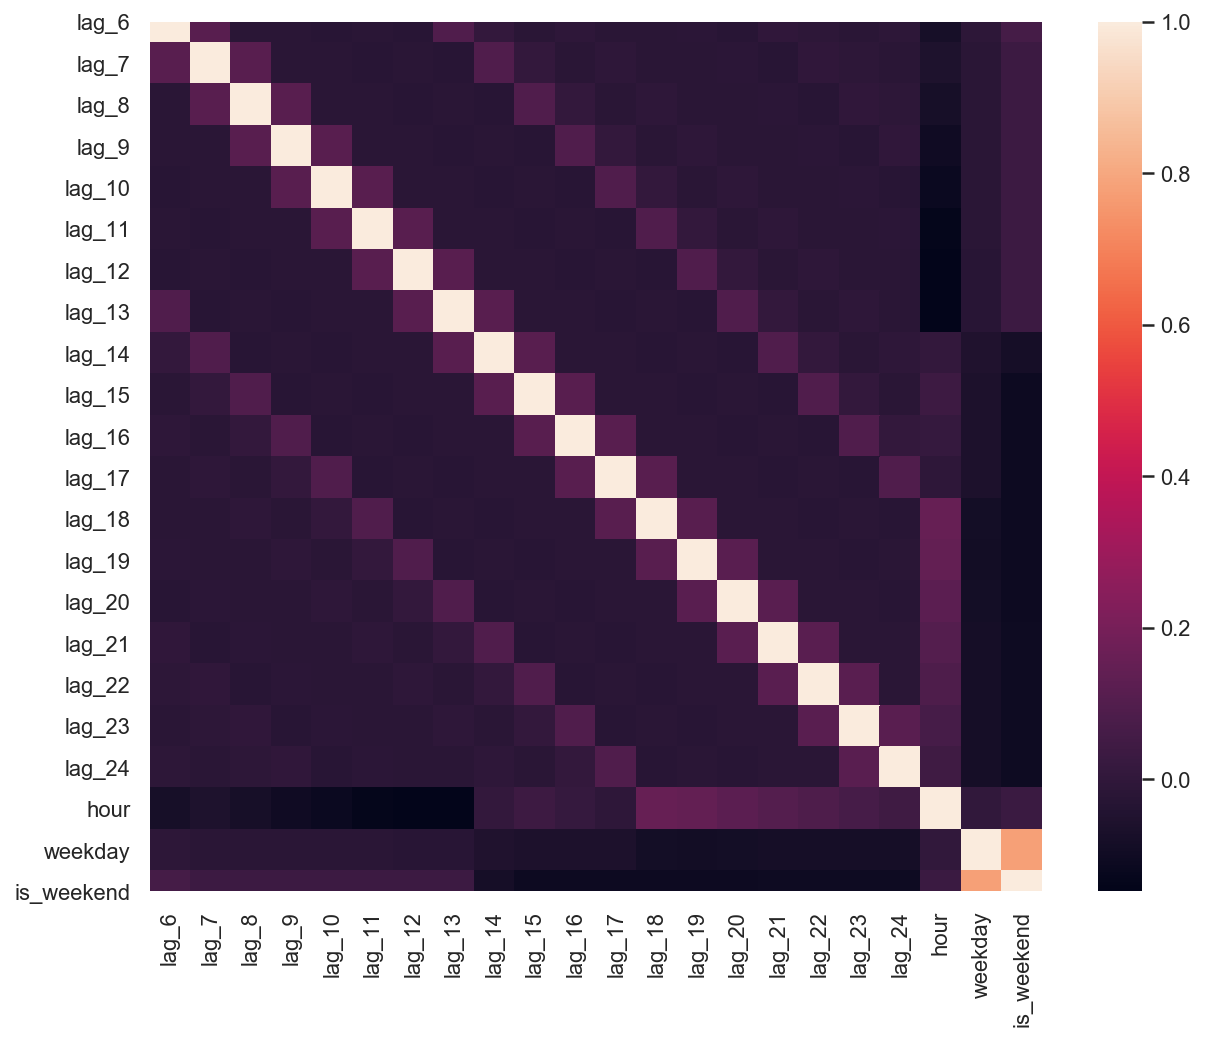

In [167]:
plt.figure(figsize=(10, 8))
sns.heatmap(X_train.corr());

0.009246874452062515


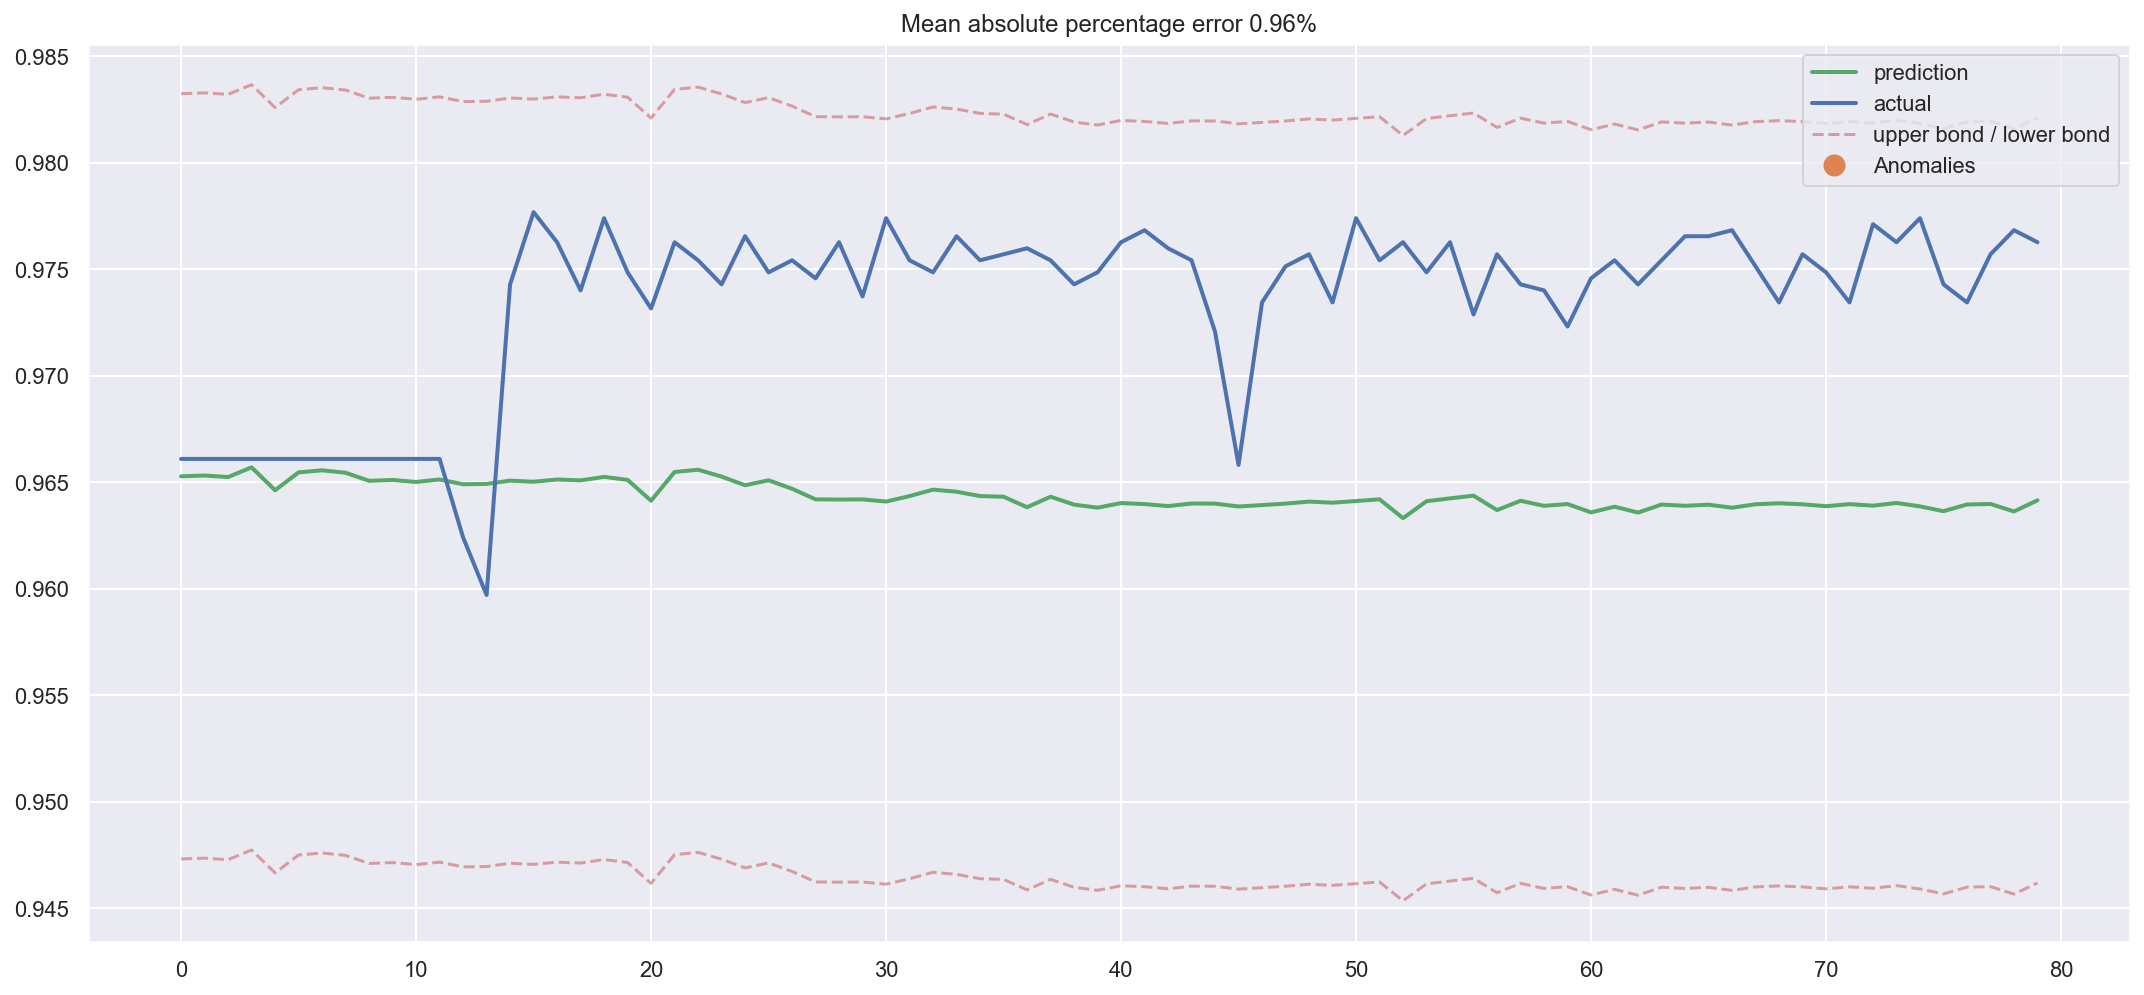

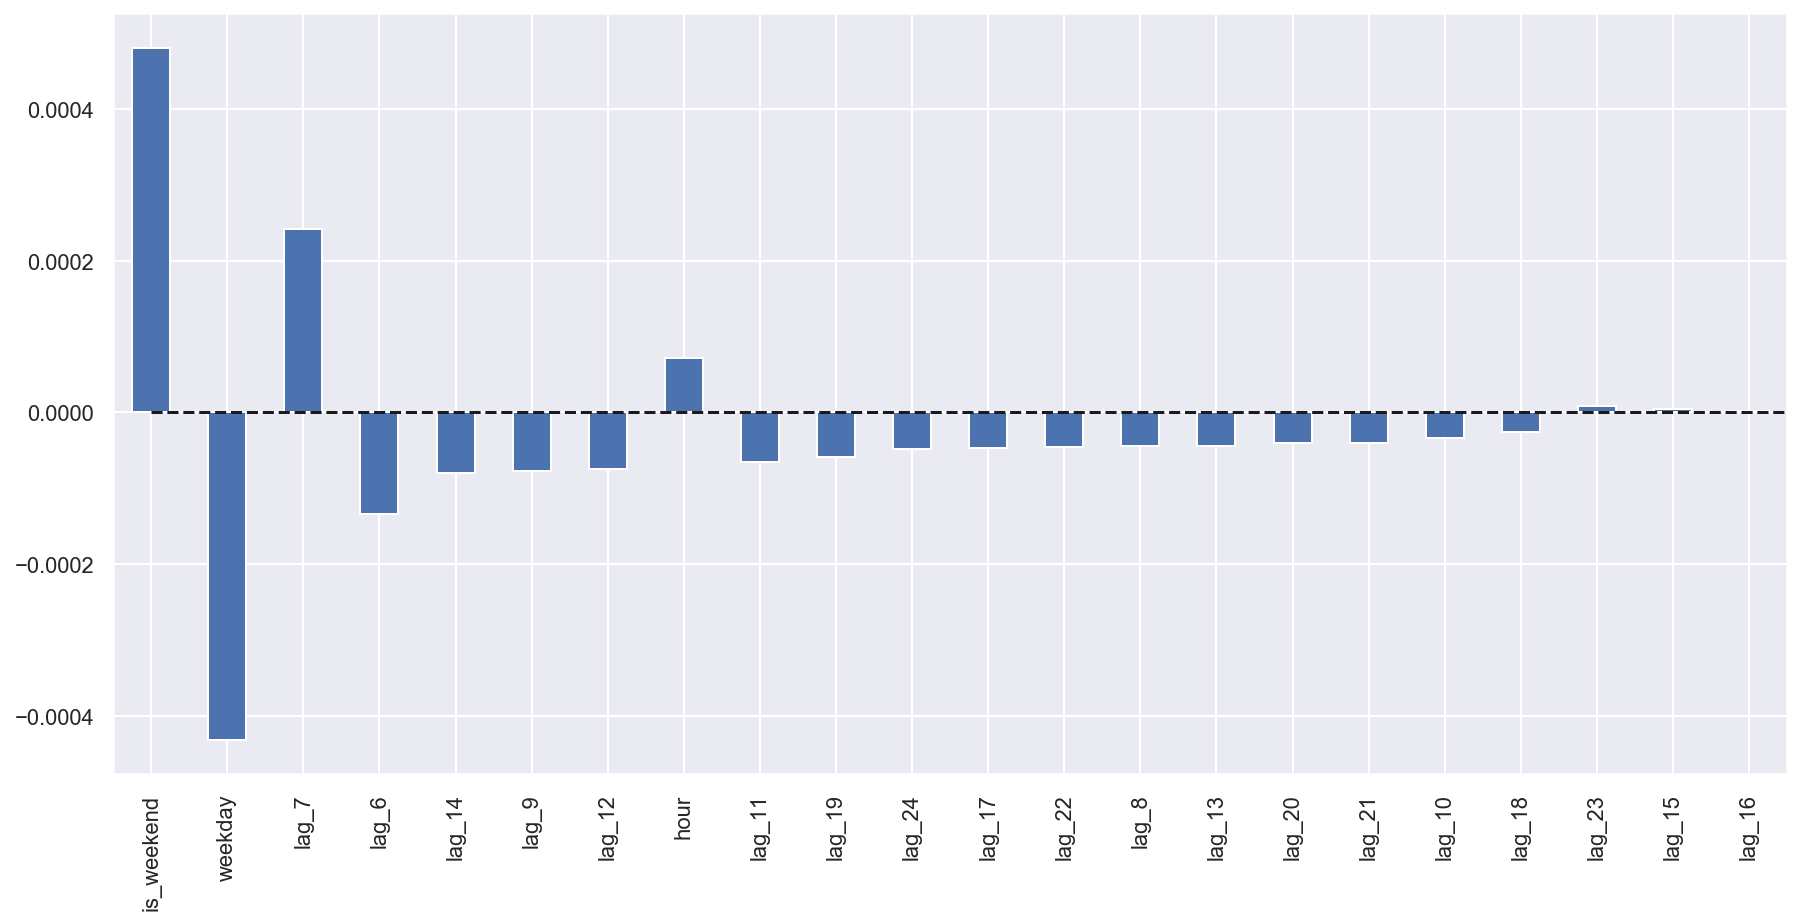

In [168]:
from sklearn.linear_model import LassoCV, RidgeCV

ridge = RidgeCV(cv=tscv)
ridge.fit(X_train_scaled, y_train)

plotModelResults(ridge, 
                 X_train=X_train_scaled, 
                 X_test=X_test_scaled, 
                 plot_intervals=True, plot_anomalies=True)
plotCoefficients(ridge)

We can clearly see some coefficients are getting closer and closer to zero (though they never actually reach it) as their importance in the model drops.

0.008076102905221722


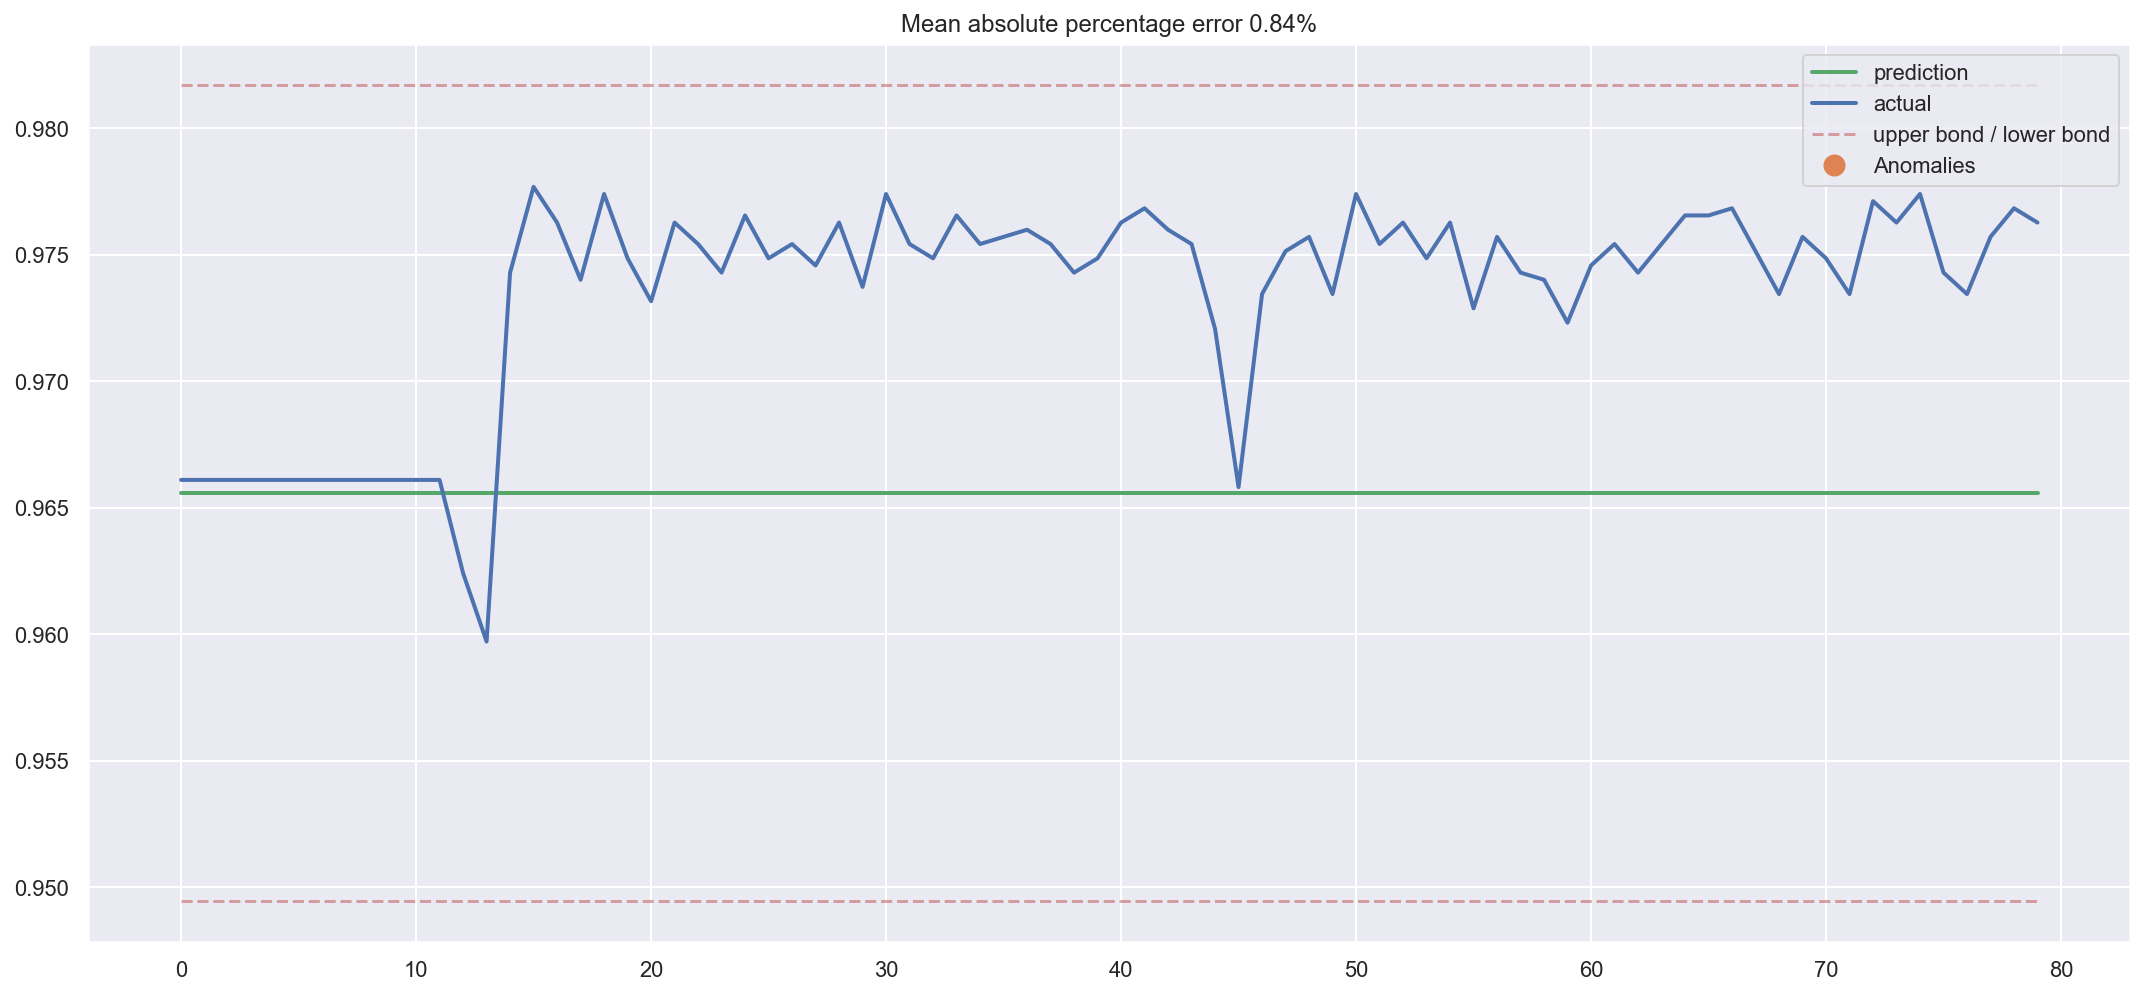

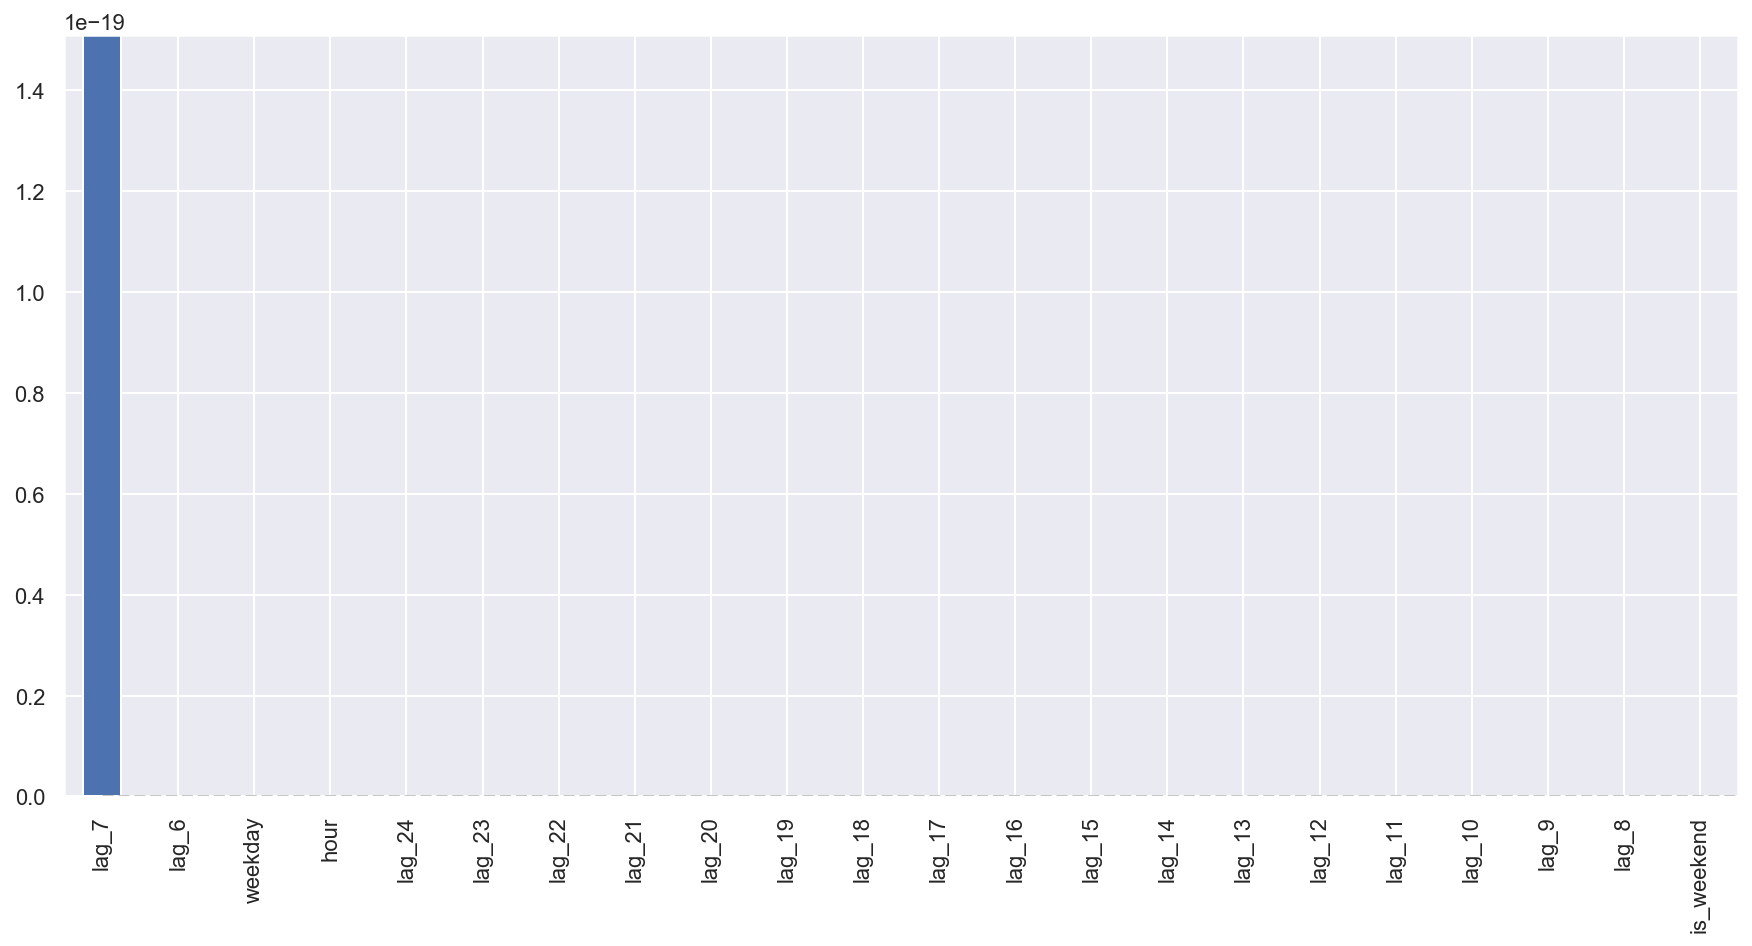

In [177]:
lasso = LassoCV(cv=5)
lasso.fit(X_train_scaled, y_train)

plotModelResults(lasso, 
                 X_train=X_train_scaled, 
                 X_test=X_test_scaled, 
                 plot_intervals=True, plot_anomalies=True)
plotCoefficients(lasso)

Lasso regression turned out to be more conservative; it removed 23-rd lag from the most important features and dropped 5 features completely, which only made the quality of prediction better.

# Boosting 
Why shouldn't we try XGBoost now?
<img src="../../img/xgboost_the_things.jpg"/>

In [170]:
from xgboost import XGBRegressor 

xgb = XGBRegressor(verbosity=0)
xgb.fit(X_train_scaled, y_train);

0.008234350799074202


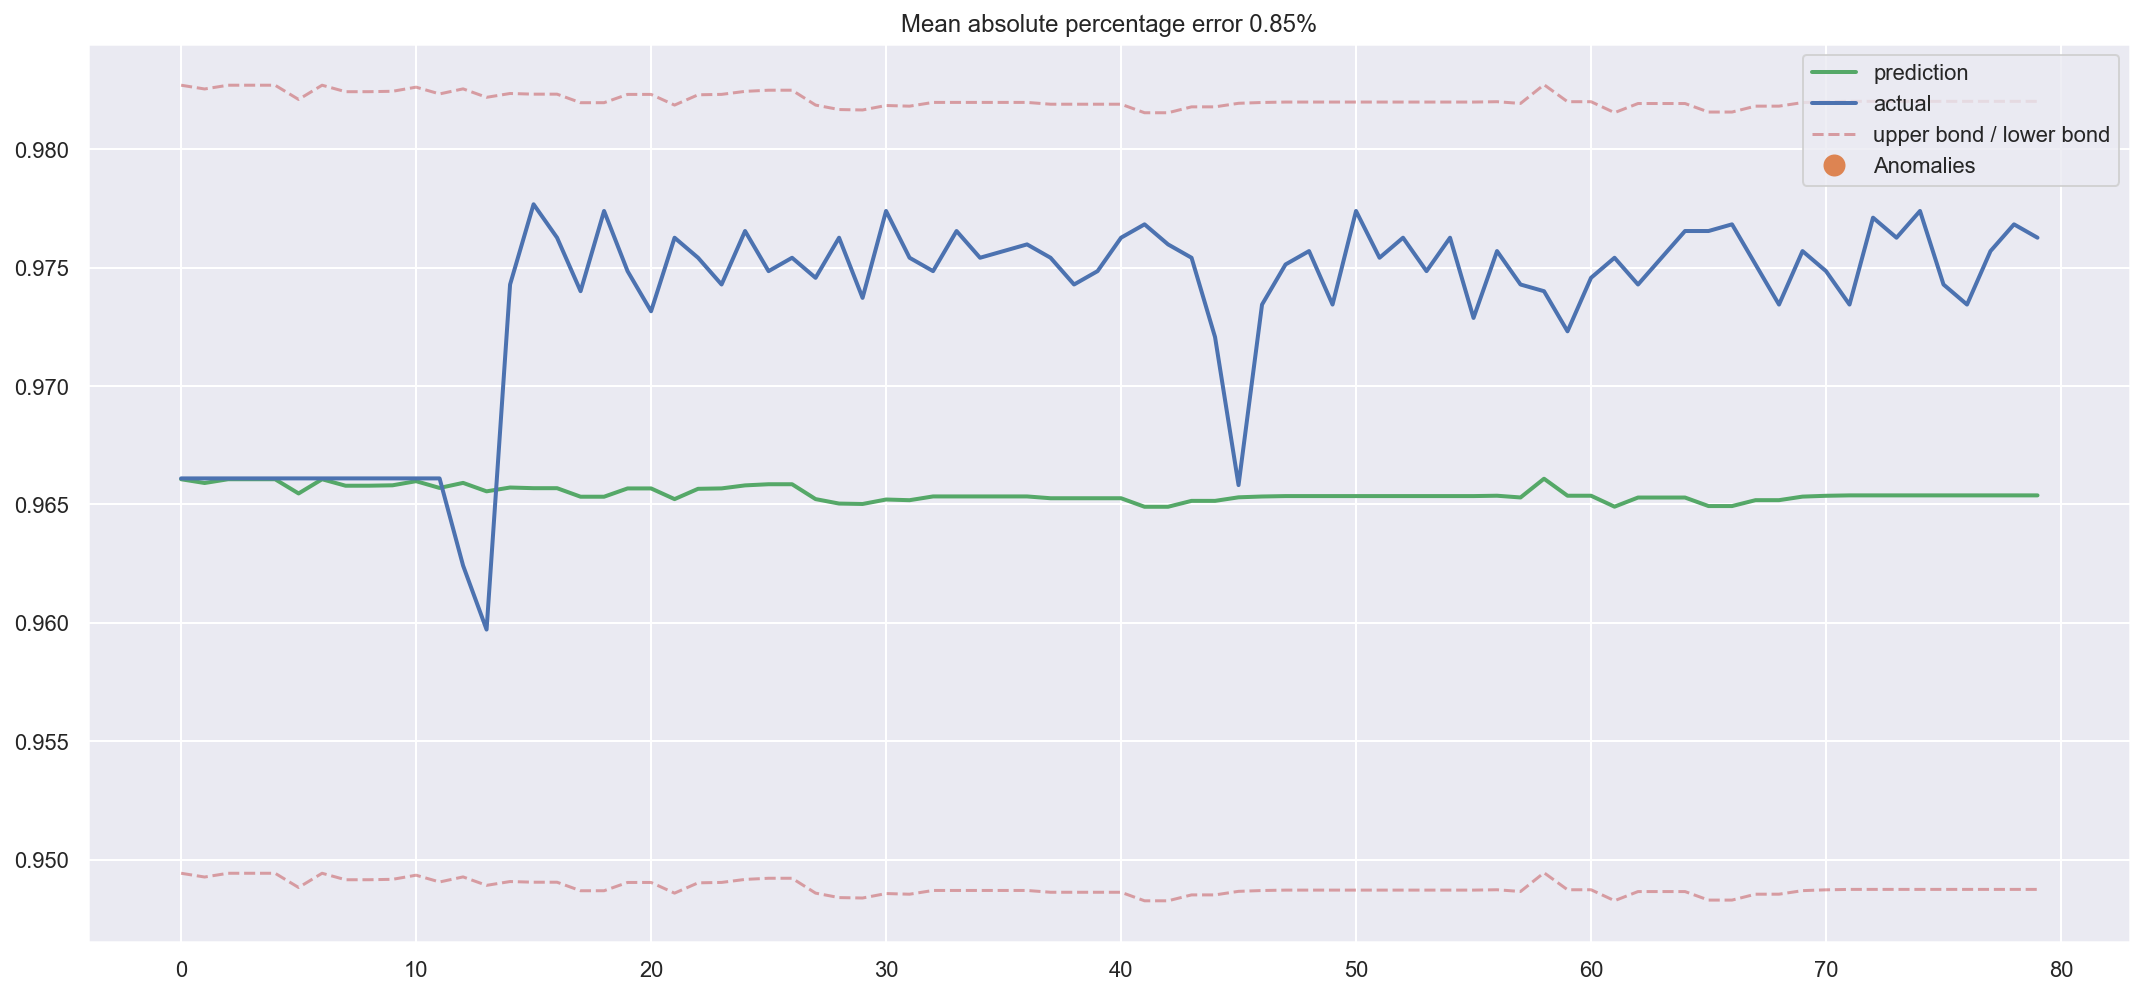

In [171]:
plotModelResults(xgb, 
                 X_train=X_train_scaled, 
                 X_test=X_test_scaled, 
                 plot_intervals=True, plot_anomalies=True)

We have a winner! This is the smallest error on the test set among all the models we've tried so far. 

But, this victory is decieving, and it might not be the brightest idea to fit `xgboost` as soon as you get your hands on time series data. Generally, tree-based models handle trends in data poorly when compared with linear models. In that case, you would have to detrend your series first or use some tricks to make the magic happen. Ideally, you can make the series stationary and then use XGBoost. For example, you can forecast trend separately with a linear model and then add predictions from `xgboost` to get a final forecast.

# Conclusion

We discussed different time series analysis and prediction methods. Unfortunately, or maybe luckily, there is no one way to solve these kind of problems. Methods developed in the 1960s (and some even in the beginning of the 21st century) are still popular, along with LSTMs and RNNs (not covered in this article). This is partially related to the fact that the prediction task, like any other data-related task, requires creativity in so many aspects and definitely requires research. In spite of the large number of formal quality metrics and approaches to parameters estimation, it is often necessary to try something different for each time series. Last but not least, the balance between quality and cost is important. As a good example, the SARIMA model can produce spectacular results after tuning but can require many hours of ~~tambourine dancing~~ time series manipulation while a simple linear regression model can be built in 10 minutes and can achieve more or less comparable results.

# Useful resources

* The same notebook as an interactive web-based [Kaggle Kernel](https://www.kaggle.com/kashnitsky/topic-9-part-1-time-series-analysis-in-python)
* "LSTM (Long Short Term Memory) Networks for predicting Time Series" - a tutorial by Max Sergei Bulaev within mlcourse.ai (full list of tutorials is [here](https://mlcourse.ai/tutorials))
* Main course [site](https://mlcourse.ai), [course repo](https://github.com/Yorko/mlcourse.ai), and YouTube [channel](https://www.youtube.com/watch?v=QKTuw4PNOsU&list=PLVlY_7IJCMJeRfZ68eVfEcu-UcN9BbwiX)
* Course materials as a [Kaggle Dataset](https://www.kaggle.com/kashnitsky/mlcourse)
* Medium ["story"](https://medium.com/open-machine-learning-course/open-machine-learning-course-topic-9-time-series-analysis-in-python-a270cb05e0b3?source=collection_home---6------2---------------------) based on this notebook
* If you read Russian: an [article](https://habr.com/ru/company/ods/blog/327242/) on Habr.com with ~ the same material. And a [lecture](https://youtu.be/_9lBwXnbOd8) on YouTube
* [Online textbook](https://people.duke.edu/~rnau/411home.htm) for the advanced statistical forecasting course at Duke University - covers various smoothing techniques in detail along with linear and ARIMA models
* [Comparison of ARIMA and Random Forest time series models for prediction of avian influenza H5N1 outbreaks](https://bmcbioinformatics.biomedcentral.com/articles/10.1186/1471-2105-15-276) - one of a few cases where using random forest for time series forecasting is actively defended
* [Time Series Analysis (TSA) in Python - Linear Models to GARCH](http://www.blackarbs.com/blog/time-series-analysis-in-python-linear-models-to-garch/11/1/2016) - applying the ARIMA models family to the task of modeling financial indicators (by Brian Christopher)